# Q-Learning Agent 
---
En este notebook se desarrolla un agente de Q-Learning que aprende a escapar de un pequeño laberinto. Para ello, se diseña un pequeño grid que recrea el puzzle de donde debe escapar, el cual incorpora una meta y un punto de "game over". Adicionalmente, se explora el diseño, testeo y optimización de políticas del agente. Para lograr el objetivo anterior, se definen algunas de las variables del agente de Q-Learning:

**1. Ambiente:** El ambiente corresponde al laberinto en donde se encuentra el agente. Este laberinto consistirá en un grid de tamaño 4x3, el cual incorporá un punto de llegada y un punto de "game over". Adicionalmente, una de las casillas del grid será innacesible (o lo que es lo mismo, tendrá un muro).

**2. Estados:** Los estados del agente corresponderán a la posición (coordenadas) en donde se encuentre. Por ejemplo, el estado del agente en el momento $t$ es $S_{t} = (1, 2)$.

**3. Acciones:** Las acciones que puede tomar el agente son: Arriba ($up$), Abajo ($down$), Derecha ($right$), Izquierda ($left$). En caso en que el agente se "estrelle con un muro", el robot vuelve al estado en donde estaba.

**4. Recompensas:** Para el caso del agente en el laberinto, se incluirá una "penalidad de vida", es decir, cada vez que el agente tome una acción, recibirá una recompensa constante $r$. Si llega a la meta, recibirá una recompensa $R_{win}$ y se pierde $R_{loss}$

<img src="https://miro.medium.com/max/725/1*NyWUkwz1QhrVJj9ygCQ5nA.png" alt="Smiley face" height="300" width="450">

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random

%matplotlib inline

In [2]:
from IPython.display import clear_output

In [3]:
import os
def clear():
    os.system( 'cls' )

In [4]:
# Set walls and paths.
walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 0, 1, 1, 1]]


# Set rewards.
rw = -1
rewards = [[0, rw, rw, rw, rw], [rw, rw, rw, rw, rw], [rw, rw, rw, rw, rw], [rw, rw, rw, rw, rw], [rw, rw, rw, -10, 10]]

In [5]:
def draw_grid(x, y, value_state_table):

        grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]
    
        fig1 = plt.figure(figsize=(4, 4))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

        # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#68FF33"))
        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#FF5533"))

        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))

        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot text reward.
        pos_correct = -.02
        #plt.text(0.9 + pos_correct, 0.9 + pos_correct, "1", fontsize=16)
        #plt.text(0.9 + pos_correct, 0.7 + pos_correct, "-1", fontsize=16)
        plt.scatter(x, y, s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)

        # Plot state values.
        for i in range(0, len(value_state_table)):
            for j in range(0, len(value_state_table[0])):
                plt.text(grid_pos[i] - 0.05, grid_pos[j] - 0.03, round(value_state_table[i][j], 0), fontsize=16)
                
        # Plot grid.
        plt.axis("off")
        plt.show()

In [6]:
# Random agent.
class randomAgent():
    
    def __init__(self):
        self.pos = [0, 0]
        self.actions = ["up", "down", "left", "right"]
        self.living_penalty = -1
        self.total_reward = 0
        
    def selectAction(self):
        action = self.actions[random.randint(0, 3)]
        return action 
    
    def move(self):
        act = self.selectAction()
        previous_pos = self.pos.copy()
        self.total_reward += self.living_penalty
        
        print("Action taken: ", act)
        
        try:
            if(act == "up" and self.pos[1] < 4):
                
                if(walls_and_paths[self.pos[0]][self.pos[1] + 1]) == 1:
                    self.pos = [self.pos[0], self.pos[1] + 1]

            elif(act == "down" and self.pos[1] > 0):

                if(walls_and_paths[self.pos[0]][self.pos[1] - 1]) == 1:
                    self.pos = [self.pos[0], self.pos[1] - 1]

            elif(act == "left" and self.pos[0] > 0):

                if(walls_and_paths[self.pos[0] - 1][self.pos[1]]) == 1:
                    self.pos = [self.pos[0] - 1, self.pos[1]]

            elif(act == "right" and self.pos[0] < 4):
                if(walls_and_paths[self.pos[0] + 1][self.pos[1]]) == 1:
                    self.pos = [self.pos[0] + 1, self.pos[1]]
        except:
            pass
        
    def getPos(self):
        return self.pos

## Random Agent.

In [23]:
grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]

agent = randomAgent()
pos = agent.getPos()
#print("Position: ", pos[0], pos[1])
draw_grid(pos[0] + 0.1, pos[1] + 0.1)

while not ((pos[0] == 4 and pos[1] == 4) or (pos[0] == 4 and pos[1] == 3)):
    print("------")
    agent.move()
    pos = agent.getPos()
    
    print("Position: ", "(", pos[0], ",", pos[1], ")")
    draw_grid(grid_pos[pos[0]], grid_pos[pos[1]])
    time.sleep(0.1)
    clear_output(wait=True)

TypeError: draw_grid() missing 1 required positional argument: 'value_state_table'

In [10]:
class valueBasedAgent():
    
    def __init__(self):
        self.pos = [0, 0]
        self.actions = ["up", "down", "left", "right"]
        self.total_reward = 0
        
        self.delta = 0
        self.sigma = 20
        self.living_penalty = -1
        self.value_state_table = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
        
        self.recursion_execution = 0
        self.max_recursion = 2
        
        
        
    def valueFunction(self, state):
        
        prob = 0.25 # Esta es la politica!
        learning_rate = 0.3
        state_value = 0
        
        for a in self.actions: 
            
            new_possible_state = self.computePossibleState(state, a)
            new_states = self.computeNewStates(new_possible_state)
            
            expected_return = 0
            
            print(new_states)
            
            for s in new_states:
                
                s_state_value = self.value_state_table[s[0]][s[1]]
                if(s_state_value != 0):
                    expected_return += ((rewards[s[0]][s[1]]) + learning_rate * self.valueFunction(s))
                else:
                    expected_return += (rewards[s[0]][s[1]])
                
            state_value += prob * expected_return 
        
        return state_value
    
    
    def computePossibleState(self, state, action):
        
        # Go up.
        if action == "up":
            if (state[1] + 1) < 4:
                if (walls_and_paths[self.pos[0]][self.pos[1] + 1] == 1):
                    up = [state[0], state[1] + 1] 
                else: 
                    up = state
            else:
                up = state
            return up
            
        # Go down.
        elif action == "down":
            if (state[1] - 1) > 0:
                if (walls_and_paths[self.pos[0]][self.pos[1] - 1] == 1):
                    down = [state[0], state[1] - 1] 
                else:
                    down = state
            else:
                down = state
            return down
        
        # Go left.
        elif action == "left":
            if (state[0] - 1) > 0:
                if (walls_and_paths[self.pos[0] - 1][self.pos[1]] == 1):
                    left = [state[0] - 1, state[1]] 
                else:
                    left = state
            else:
                left = state
            return left
            
        # Go right.
        elif action == "right":
            if (state[0] + 1) < 4:
                if (walls_and_paths[self.pos[0] + 1][self.pos[1]] == 1):
                    right = [state[0] + 1, state[1]] 
                else:
                    right = state
            else:
                right = state
            return right
        
    
    def computeNewStates(self, state):
        
        up = self.computePossibleState(state, "up")
        down = self.computePossibleState(state, "down")
        left = self.computePossibleState(state, "left")
        right = self.computePossibleState(state, "right")
        return [up, down, left, right]
        
        
    def updateValueStateTable(self, value_state_table, state = [0, 0]):
        
        new_table = value_state_table
        new_state_value = self.valueFunction(state)
        new_table[state[0]][state[1]] = new_state_value
        return new_table
        
    def selectAction(self):
        action = self.actions[random.randint(0, 3)]
        return action 
    
    def move(self):
        
        # Select action.
        act = self.selectAction()
        print("Action taken: ", act)
        
        # Move the player.
        try:
            if(act == "up" and self.pos[1] < 4):
                
                if(walls_and_paths[self.pos[0]][self.pos[1] + 1]) == 1:
                    self.pos = [self.pos[0], self.pos[1] + 1]

            elif(act == "down" and self.pos[1] > 0):

                if(walls_and_paths[self.pos[0]][self.pos[1] - 1]) == 1:
                    self.pos = [self.pos[0], self.pos[1] - 1]

            elif(act == "left" and self.pos[0] > 0):

                if(walls_and_paths[self.pos[0] - 1][self.pos[1]]) == 1:
                    self.pos = [self.pos[0] - 1, self.pos[1]]

            elif(act == "right" and self.pos[0] < 4):
                if(walls_and_paths[self.pos[0] + 1][self.pos[1]]) == 1:
                    self.pos = [self.pos[0] + 1, self.pos[1]]
        except:
            pass
        
        # Update the Value State Table.
        self.value_state_table = self.updateValueStateTable(self.value_state_table, state = self.pos)
        
    def getPos(self):
        return self.pos
    
    def getTotalReward(self):
        return self.total_reward
    
    def giveReward(self, points):
        self.total_reward += points

## Value Based Agent.

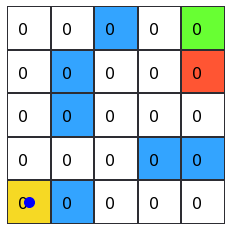

------
Action taken:  right
[[0, 2], [0, 1], [0, 1], [0, 1]]
[[0, 1], [0, 0], [0, 0], [0, 0]]
[[0, 1], [0, 0], [0, 0], [0, 0]]
[[0, 1], [0, 0], [0, 0], [0, 0]]
Position:  ( 0 , 0 )


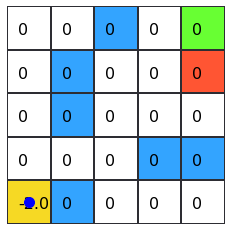

------
Action taken:  up
[[0, 3], [0, 1], [0, 2], [1, 2]]
[[0, 2], [0, 1], [0, 1], [1, 1]]
[[0, 2], [0, 1], [0, 1], [1, 1]]
[[1, 2], [1, 1], [1, 1], [2, 1]]
Position:  ( 0 , 1 )


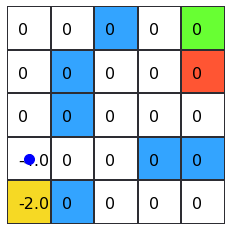

------
Action taken:  down
[[0, 2], [0, 1], [0, 1], [0, 1]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1],

[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [

[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [0, 1], [0, 2], [0, 2]]
[[0, 3], [

RecursionError: maximum recursion depth exceeded while calling a Python object

In [11]:
grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]

agent = valueBasedAgent()
pos = agent.getPos()
#print("Position: ", pos[0], pos[1])
draw_grid(pos[0] + 0.1, pos[1] + 0.1, agent.value_state_table)

while not ((pos[0] == 4 and pos[1] == 4) or (pos[0] == 4 and pos[1] == 3)):
    print("------")
    agent.move()
    pos = agent.getPos()
    
    print("Position: ", "(", pos[0], ",", pos[1], ")")
    draw_grid(grid_pos[pos[0]], grid_pos[pos[1]], agent.value_state_table)
    time.sleep(0.1)
    #clear_output(wait=True)

In [2]:
import sys
sys.getrecursionlimit


<function sys.getrecursionlimit>

In [16]:
sys.getrecursionlimit()

3000

In [3]:
sys.setrecursionlimit(3000)

In [21]:
# Grid World characteristics.
class GridWorld():
    
    def __init__(self):
        
        # Grid walls and paths.
        self.walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 0, 1, 1, 1]
        
        # Value State table.
        self.value_state_table = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
        
        # Initialize random agent.
        self.agent = randomAgent()
                                
    # Dynaminc Programming.
    def stateValue(self):
        
        return ""
    
    def actionStateValue(self):
        return ""
 
    # Draw Grid.
    def draw_grid(x, y):

        fig1 = plt.figure(figsize=(4, 4))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

        # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#68FF33"))
        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#FF5533"))

        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))

        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot text reward.
        pos_correct = -.02
        plt.text(0.9 + pos_correct, 0.9 + pos_correct, "1", fontsize=16)
        plt.text(0.9 + pos_correct, 0.7 + pos_correct, "-1", fontsize=16)
        plt.scatter(x, y, s = 100, color = "black", marker = "x", edgecolors = "black", zorder = 10)

        # Plot grid.
        plt.axis("off")
        plt.show()

                 
# Initialize GridWorld obj.
gridworld = GridWorld()

In [ ]:
class GridWorld():
    
    def __init__(width = 5, height = 5, living_penalty = 0):
        self.width = width
        self.height = height
        
        # Value State table.
        value_state_table = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
        
        # State value matrix.
        """
        state_matrix = list()
        for i in range(0, height):
            row_values = list()
    
            for j in range(0, width):
                row_values.append(self.living_penalty)
            state_matrix.append(row_values)
        
        # Action State value matrix.
        action_state_matrix = list()
        for i in range(0, height):
            row_values = list()
            for j in range(0, width):
                state_q_values = list()
                
                for k in range(0, 4):
                    state_q_values.append(0)
                    
                row_values.append(state_q_values)
            action_state_matrix.append(row_values)
        """
                    
    def stateValue():
        return ""
    
    def actionStateValue():
        return ""